# 1. Introduction

### 1.1 Motivation 

Forward uncertainty quantification (UQ) analysis aims to quantify the model prediction uncertainty given the input data uncertainties, which include model parameter uncertainties, initial condition uncertainties, boundary condition uncertainties, etc. It is called "forward" as the uncertainty information flows from the input, throught the model, to the output. Forward UQ analysis is a crucial step towards robust decision-making, as the reliability of the model prediction results is carefully examined by taking into account the input data variabilities. 

### 1.2 Objective

In this notebook, I will demonstrate how to perform forward UQ analysis using Monte Carlo simulation. We will go through three key steps of a typical forward UQ analysis: random sample generation, uncertainty propagation, and uncertainty visualization. 

### 1.3 Case study

The case study we will consider employs an epidemic model to predict the spread of a disease in a population. In this case study, the infection rate and recovery rate are considered as the uncertain parameters. Our output of interests are the maximum infection number during the course of disease spreading and its occurence time. 

By performing the forward UQ analysis, we could better understand how the output of interest will vary under the influence of the uncertain model parameters. This information is vital for supporting effective and robust decision-making in disease spreading control.

### 1.4 Notebook structure

We will start by introducing the problem statement of the current case study. Then, we will dive into the forward UQ analysis, which consists of the following three steps:

1. Random sample generation. In this step, we will create representative samples of the uncertain input parameters via a Latin Hypercube method.

2. Uncertainty propagation. In this step, we will employ a Monte Carlo approach to propagate uncertainty from the inputs to the outputs. 

3. Uncertainty visualization. In this step, we will visualize the output uncertainties using a technique called [**Hypothetical Outcome Plots**](https://towardsdatascience.com/uncertainty-visualization-made-easy-with-hypothetical-outcome-plots-89558574d069). 

Finally, we will discuss some of the challenges and possible solutions in performing forward UQ analysis in practice.

In [1]:
# import all packages and set plots to be embedded inline
from pyDOE import lhs
from scipy.integrate import odeint
from scipy.stats.distributions import norm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from celluloid import Camera

%matplotlib inline
np.set_printoptions(precision=2,suppress=True)
np.random.seed(42)

# 2. Problem Statement

### 2.1 Background 

In this case study, we model the spread of a disease in a population by using the **SIR** model. In its basic form, this model divides the total population $N$ into three distinct compartments that vary as functions of time $t$:

- $S(t)$, the number of individuals who are **S**usceptible but not yet infected with the disease;
- $I(t)$, the number of individuals who are **I**nfected;
- $R(t)$, the number of individuals who are have **R**ecovered from and immune to the disease.

The SIR model describes the time evolution of the $S(t), I(t)$ and $R(t)$ populations with the following system of ordinary differential equations:

\begin{align}
\frac{dS}{dt} &= -\frac{\beta SI}{N}, \\
\frac{dI}{dt} &= \frac{\beta SI}{N} - \gamma I, \\
\frac{dR}{dt} &= \gamma I,
\end{align}

where $\beta$ denotes the infection rate and $\gamma$ represents the recovery rate.

### 2.2 Uncertainty description

We consider the infection rate $\beta$ and recovery rate $\gamma$ as the two uncertain model parameters. Those model parameters may not be fully known when facing an outbreak of a new disease (e.g., COVID-19). 

In practice, official records concerning the evolution of the number of infected and recovered patients are used to estimate $\beta$ and $\gamma$. Unfortunately, the records may not be reliable, especially at the early stage of the outbreak. Consequently, $\beta$ and $\gamma$ estimation from the "noisy" data will be uncertain. Deriving parameter estimation uncertainty is in the domain of **system identification**, and it happens before the forward UQ analysis.

Since our current case study focuses on the forward UQ analysis, we will simply assume that the $\beta-\gamma$ estimation work has already been done, and their uncertainties are characterized by a bivariate normal distribution:

\begin{equation}
\begin{pmatrix} 
\beta \\ \gamma 
\end{pmatrix} \sim \mathcal{N}
\begin{pmatrix} 
\begin{pmatrix} 
0.22 \\ 0.1
\end{pmatrix}, &
\begin{pmatrix} 
2e^{-4} & 4e^{-5} \\ 4e^{-5} & 1e^{-4} 
\end{pmatrix}
\end{pmatrix},
\end{equation}

Running SIR model also requires other parameters besides $\beta$ and $\gamma$:

- $I0$, number of initial infected individuals;
- $R0$, number of initial recovered/immune individuals;
- $N$, the population size.

For the current study, we tream the above three parameters as known constants, with $I0=8$, $R0=0$, and $N=1000$.

### 2.3 Methodology

We will use Monte Carlo simulation to address the current case study. Monte Carlo simulation is a simple yet powerful uncertainty propagation method. It enables us to generate representative samples from the target output distribution without knowing the distribution form, which can be simply done via simulating the outputs under various input scenarios. Later on, we can retrieve the output distribution based on the accumulated samples. 

Conduting Monte Carlo simulation involves the following three steps:

1. Draw a large number of random *samples* of $\beta$ and $\gamma$ from their probability distribution (i.e., bivariate normal);

2. For each sample, insert its $\beta$ and $\gamma$ values into the SIR model, and run the SIR model to predict the outputs of interest, i.e., maximum infection number and its occurence time;

3. Based on the ensemble of predictions, we can estimate the joint/marginal probability distributions of the two outputs.

First, let's define the function to run the SIR model.

In [2]:
# Define the function to calculate S, I, R evolution
def SIR_model(beta, gamma, t, N, I0, R0):
    """The function implements the SIR model to calculate 
    the disease spreading.
    
    Input:
    - N: Population size
    - I0, R0: Initial infected individuals and recovered/immunity individuals
    - t: A grid of time points (in days)
    - beta: Infection rate
    - gamma: Recovery rate
    
    Output:
    - S: Number of susceptible individuals
    - I: Number of infected individuals
    - R: Number of recovered/immune individuals"""
    
    S0 = N - I0 - R0
    
    def deriv(y, t, N, beta, gamma):
        S, I, R = y
        dSdt = -beta * S * I / N
        dIdt = beta * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt
    
    ret = odeint(deriv, [S0, I0, R0], t, args=(N, beta, gamma))
    
    return ret.T 

To get an intuitive understanding of the SIR model prediction results, we could run the SIR model with specific parameters. Here, we assign $\beta=0.22$ and $\gamma=0.1$. 

In [3]:
# Assign infection and recovery rate parameters
beta, gamma = 0.22, 0.1

# Grid of time points
t = np.arange(0, 101, 2)

# Run SIR model to predict epidemic evolution
S, I, R = SIR_model(beta, gamma, t, I0=8, N=1000, R0=0)

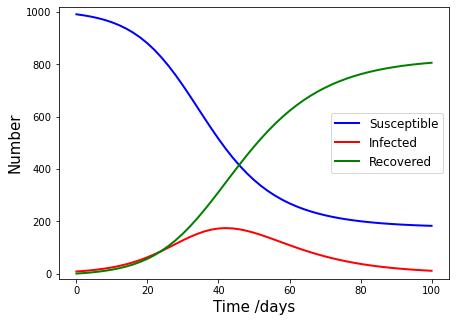

In [23]:
# Visualize epidemic evolution
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(t, S, 'b', lw=2, label='Susceptible')
ax.plot(t, I, 'r', lw=2, label='Infected')
ax.plot(t, R, 'g', lw=2, label='Recovered')
ax.set_xlabel('Time /days', fontsize=15)
ax.set_ylabel('Number', fontsize=15)
ax.set_ylim(-20,1020)
ax.legend(loc="center right",prop={'size': 12});
plt.savefig('./images/sample_evolution.png')

In [5]:
# Extract output of interest
max_infection = I.max() 
max_time = t[I.argmax()]

# Print out info
print('The maximum number of infected individuals is {},'.format(max_infection))
print('which happens {} days after the out break.'.format(str(max_time)))

The maximum number of infected individuals is 190.5384707171233,
which happens 40 days after the out break.


From the above figure, we can see that as more people get recovered, the susceptible and infected populations drop down significantly. The number of infected individuals peaks 40 days after the outbreak, reaching a total of 190 affected people.

# 3 Random sample generation

In this step, we will use Latin Hypercube method to generate representative samples of the uncertain input parameters. Those generated samples will be used in the subsequent Monte Carlo simulations.

### 3.1 Latin Hypercube sampling

Latin Hypercube sampling (LHS) is an advanced sampling method aiming at generating "space-filling" samples. Compared with the naive random sampling approach (such as `numpy.random.rand`), Latin Hypercube samples can largely avoid clusters and gaps in the parameter space (see figure below), therefore filling the entire parameter space evenly. This property is desired in the Monte Carlo simulation as it improves the estimation accuracy.

<img src="./images/LHS_Over_Random.png" width=500 height=300 />

In the current study, we adopt the LHS implementation from the `pyDOE` package to generate samples. `pyDOE` is a package designed to help the scientist, engineer, statistician, etc., to construct appropriate experimental designs. [Read more here](https://pythonhosted.org/pyDOE/). 

To install `pyDOE`, simply use `pip install pyDOE`.

### 3.2 Sample transformation

The samples created by `pyDOE.lhs` are distributed uniformly within [0, 1]. As a result, we need to perform **sample transformation** to turn the obtained samples into the previously specified bivariate normal distribution. 

The overall sampling process involves three steps:

1. **Use** `pyDOE.lhs` **to generate samples from an uniform distribution $\mathcal{U}(0,1)$.**

In [14]:
# Specify random sample number
sample_num = 1000

# Using Latin Hypercube method to generate uniform distribution
uni_samples = lhs(n=2, samples=sample_num, criterion='maximin')

For the function `pyDOE.lhs`, it takes in three parameters:

- n: the number of parameters (an integer);
- samples: the number of samples to generate (an integer);
- criterion: determins how `lhs` will sample the points (a string).

So for this case, I instructed `pyDOE.lhs` to generate 1000 samples for 2 parameters, using *maxmin* criterion, which maximizes the minimum distance between sample points. For other available options in *criterion*, [check here](https://pythonhosted.org/pyDOE/randomized.html). 

The generated 2D array `uni_samples` has 1000 rows and 2 columns, where each column holds 1000 random realizations drawn from a uniform distribution $\mathcal{U}(0,1)$.

2. **Transform the uniform distribution to the standard normal distribution.**
    
For each column of `uni_samples`, we will map those values drawn from a uniform distribution $\mathcal{U}(0,1)$ into those of a standard normal distribution $\mathcal{N}(0,1)$.

We apply [**inverse transformation**](https://towardsdatascience.com/practical-probability-theory-all-about-a-single-random-variable-8935cfa21a96#e514) to achieve that goal. This transformation process is illustrated in the figure below, where the blue curve is the cumulative distribution function of a standard normal random variable.



In [15]:
# Transforming to standard normal distribution
std_norm_samples = np.zeros_like(uni_samples)
for i in range(2):
    std_norm_samples[:,i] = norm(loc=0, scale=1).ppf(uni_samples[:,i])

3. **Transform standard normal distribuion to the target normal distribution.**

The relationship between a $N$-dimensional multivariate normal distribution $Y \sim \mathcal{N}(\boldsymbol{\mu},\boldsymbol{\Sigma})$ and a $N$-dimensional independent standard normal distribution $Z \sim \mathcal{N}(\boldsymbol{0},\boldsymbol{I})$ can be described as the following:

\begin{equation}
Y = \boldsymbol{\mu} + ZL^{T},
\end{equation}

where $L$ is the lower-triangular matrix obtained by applying the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) to the covariance matrix $\boldsymbol{\Sigma}$. Here, both $Y$ and $Z$ are row vectors of random variables.

Based on the above-mentioned theorem, we first apply Cholesky decomposition to the covariance matrix of our target normal distribution to get $L$. Then, we use the above equaiton to turn the standard, normal distributed samples obtained from last step into the samples that follow our target bivariate normal distribution.

In [16]:
# Specify parameter distribution
mean_val = np.array([0.22,0.1])
cov_val = np.array([[2e-4, 4e-5],[4e-5,1e-4]])

# Transforming to the target distribution
L = np.linalg.cholesky(cov_val)
target_samples = mean_val + std_norm_samples.dot(L.T)
beta_samples, gamma_samples = target_samples[:,0], target_samples[:,1]

We can visualize the transformed samples.

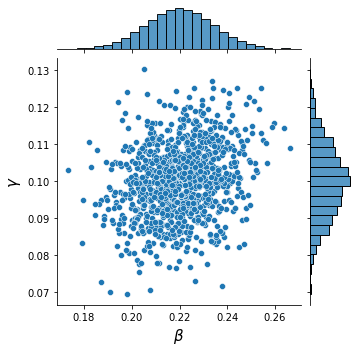

In [17]:
# Visualize samples
df_samples = pd.DataFrame({r"$\beta$":beta_samples,
                          r"$\gamma$":gamma_samples})

plt.rcParams["axes.labelsize"] = 15
sns.jointplot(data=df_samples, x=r"$\beta$", y=r"$\gamma$", height=5);

From the marginal distributions we can see that both $\beta$ and $\gamma$ are indeed following normal distributions, centered at 0.22 and 0.1, respectively. In addition, we can see from the scatter plot that the $\beta$ and $\gamma$ samples are positively correlated. This matches with the fact that the off-diagonal term ($4e^{-5}$) of the target covariance matrix is positive.  

# 4. Monte Carlo simulation

Now we are ready to perform Monte Carlo simulations. This step is simply: we just need to create a loop to predict the evolution of S, I, and R for each sample of $\beta$ and $\gamma$.

In [18]:
# Monte Carlo simulation
susceptible, infection, recovery = (np.zeros((t.shape[0], sample_num)) for i in range(3))

for i in range(sample_num):
    S, I, R= SIR_model(beta_samples[i], gamma_samples[i],
                       t, I0=8, N=1000, R0=0)
    
    susceptible[:,i] = S
    infection[:,i] = I
    recovery[:,i] = R

# Extract the output of interests
max_infection = infection.max(axis=0)  
max_time = t[infection.argmax(axis=0)]

# 5. Uncertainty visualization

Now we are able to visualize the obtained results. To present the output uncertainties, natural choices include histograms and scatter plot (since we have two outputs). `Seaborn` package offers `jointplot` function, which allows to simultaneously display the joint distribution of the variables, as well as the marginal distributions of individual variables.

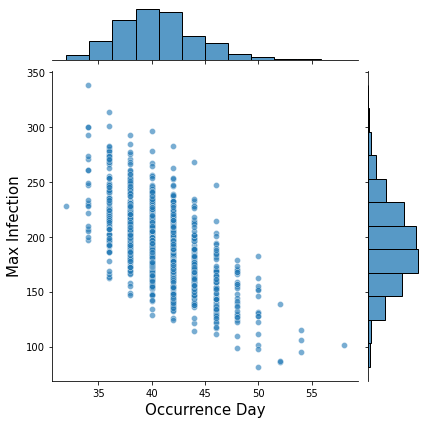

In [22]:
# Visualize output uncertainty
outputs = pd.DataFrame({"Max Infection":max_infection,
                          "Occurrence Day":max_time})

plt.rcParams["axes.labelsize"] = 15
h = sns.jointplot(data=outputs, x="Occurrence Day", y="Max Infection", 
                  # xlim=(5,165), ylim=(-20,1120),
                  marginal_kws=dict(bins=12),
                  alpha=0.6,
                  height=6)
# h.ax_joint.set_xticks([30])

From the figure above, we can have intuitive understandings of how the outputs are varying given the uncertain input parameters. There are several things we may notice:

- both the highest number of infected cases and its occurrence day appear to be normally distributed;
- the most likely scenario is that the number of infected cases climbs up to a maximum of $180 \sim 200$, which occurs $38 \sim 40$ days after the outbreak;
- the highest number of infected cases and its occurrence day is negatively correlated. This could mean that if the number of infected cases reaches its highest early, this number also tends to be high.

We can ask more questions based on the obtained results, for example:

- what $\beta-\gamma$ combinations drive the highest number of infected cases exceed a certain threshold?
- which parameter ($\beta$ or $\gamma$) contributes more to the variations of the two outputs?
- how should we reduce the uncertainty of the output predictions?

To answer those questions, we need to further conduct **global sensitivity analysis** and **robust design analysis**. They are out of the scope of the current case study.

# 6. Hypothetical Outcome Plots

In addition to static visualizations, we could make our results presentation more vivid and intuitive by using a data visualization technique called **hypothetical outcome plots**, which is especially good at communicating analysis uncertainty to broader audiences, such as stakeholders, domain experts, etc., who don’t necessarily have a strong background in statistics.

Basically, hypothetical outcome plots works by creating animations to cycle through a number of different plots, each of which simulates one possible scenario drawn from the outcome distribution. For more details on this, [check this post](https://towardsdatascience.com/uncertainty-visualization-made-easy-with-hypothetical-outcome-plots-89558574d069). For tutorial on how to create animations with `celluloid`, [take a look at this article](https://towardsdatascience.com/a-hands-on-tutorial-for-creating-matplotlib-animations-254fc7d52ed6?source=your_stories_page-------------------------------------).

In the following, we will use `celluloid` package to create animation. The generated animation serves two purposes: first, it simulates the evolution of the susceptible, infected, and recovered cases under various $\beta-\gamma$ combinations. In addition, it captures the highest number of infected cases and its occurrence day in a scatter plot.

In [12]:
# Set up the graph
fig = plt.figure(figsize=(7,5))
ax_show = plt.subplot2grid((6, 1), (0, 0), rowspan=5, colspan=1)
ax_hide = plt.subplot2grid((6, 1), (5, 0), rowspan=1, colspan=1)

ax_show.set(xlim=(-5, 105), ylim=(-20,1020))
ax_show.set_xlabel('Time /days', fontsize=15)
ax_show.set_ylabel('Number', fontsize=15)

# A work-around to prevent cropping the labels when saving gif
ax_hide.axis('off')

# Enrich scatter data in each iteration
scatter_x, scatter_y = [], []

# Initiate camera
camera = Camera(fig)

# Create individual frames
for i in range(5):
    for j in range(1, t.shape[0]+1):
    
        # Add three trajectories
        ax_show.plot(t[:j], susceptible[:j,i], 'b', lw=2, label='Susceptible')
        ax_show.plot(t[:j], infection[:j,i], 'r', lw=2, label='Infected')
        ax_show.plot(t[:j], recovery[:j,i], 'g', lw=2, label='Recovered')
    
        # Add scatter plot
        if t[j-1]==max_time[i]:
            scatter_x.append(max_time[i])
            scatter_y.append(max_infection[i])
        ax_show.scatter(scatter_x, scatter_y, c='r', alpha=0.8)
        
        # Add legend (only plot in the beginning)
        if i==0 and j==1:
            ax_show.legend(loc="center right",prop={'size': 12})
    
        # Capture frame
        camera.snap()

    # Stop the static plot from displaying
plt.close()

In [13]:
# Create animation
anim = camera.animate(interval = 20, repeat = True, repeat_delay = 500)

# Inline display
HTML(anim.to_html5_video())